In [1]:
import os

In [2]:
# check if in colab

using_colab = 'COLAB_RELEASE_TAG' in os.environ

if using_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    os.chdir('/content/drive/MyDrive/HDA/HDA-lymphoma-classification')

    # pull changes
    ! git pull

    DATASET_DIR = '/content/drive/MyDrive/HDA/lymphoma'
    

else:
    DATASET_DIR = 'C:\\Users\\loren\\Datasets\\lymphoma'



In [3]:
from lymphoma_dataset import LymphomaDataset
import tensorflow as tf
from models import EfficientNet, Inception_v4, ResNet50, CNN


In [4]:
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [19]:
## RUN PARAMETERS ##

SEED = 42

# DATASET PARAMETERS #

train_val_test_split = [0.6, 0.2, 0.2] # train, val, test split fractions
PATCH_SIZE = 299 # size of the patches
PATCH_STRIDE = PATCH_SIZE // 2 # if equal to PATCH_SIZE, no overlap
COLOR_SPACE = 'rgb' # 'rgb' or 'gray' or 'lab' or 'hed'
BATCH_SIZE = 32 # number of patches per batch

# MODEL PARAMETERS #

INPUT_CHANNELS = 1 if COLOR_SPACE == 'gray' else 3

# Dataset

In [20]:
preprocess_fn_kwargs = {'patch_sizes': [1, PATCH_SIZE, PATCH_SIZE, 1], 'patch_strides': [1, PATCH_STRIDE, PATCH_STRIDE, 1],
                        'patch_rates': [1, 1, 1, 1], 'patch_padding': 'VALID',
                        'color_space': COLOR_SPACE}

dataset_kwargs = {'batch_size': BATCH_SIZE,
                  'cache_file': 'cache_' + COLOR_SPACE + '_' + str(PATCH_SIZE), # if 'memory', the dataset will be cached in memory (risk of OOM)
                  'shuffle': True, # whether to shuffle the dataset, set it to false to get predictions for each image
                  'buffer_size': 10*BATCH_SIZE,
                  'num_parallel_calls': 2, # enough to saturate the GPU compute capabilities
                  'extract_patches': True, # if False, the dataset will return the whole image
                  'reshape_patches': True} # if False returns a 5D tensor (batch, num_patches, patch_size, patch_size, channels) instead of a 4D tensor (batch*num_patches, patch_size, patch_size, channels)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical', seed=SEED), # flip horizontally and vertically
    tf.keras.layers.RandomTranslation(0.1, 0.1, seed=SEED), # -10% to 10% translation
    tf.keras.layers.RandomRotation(0.5, seed=SEED) # -90 to 90 degrees
])

dataset = LymphomaDataset(dataset_path=DATASET_DIR, data_augmentation=data_augmentation,
                          preprocess_fn_kwargs=preprocess_fn_kwargs, dataset_kwargs=dataset_kwargs,
                          train_val_test_split=train_val_test_split, seed=SEED)

num_patches_per_image = dataset.num_patches_per_image

train_dataset, val_dataset, test_dataset = dataset.get_datasets()
train_steps, val_steps, test_steps = dataset.get_steps()

(32, 299, 299, 3) (32,)


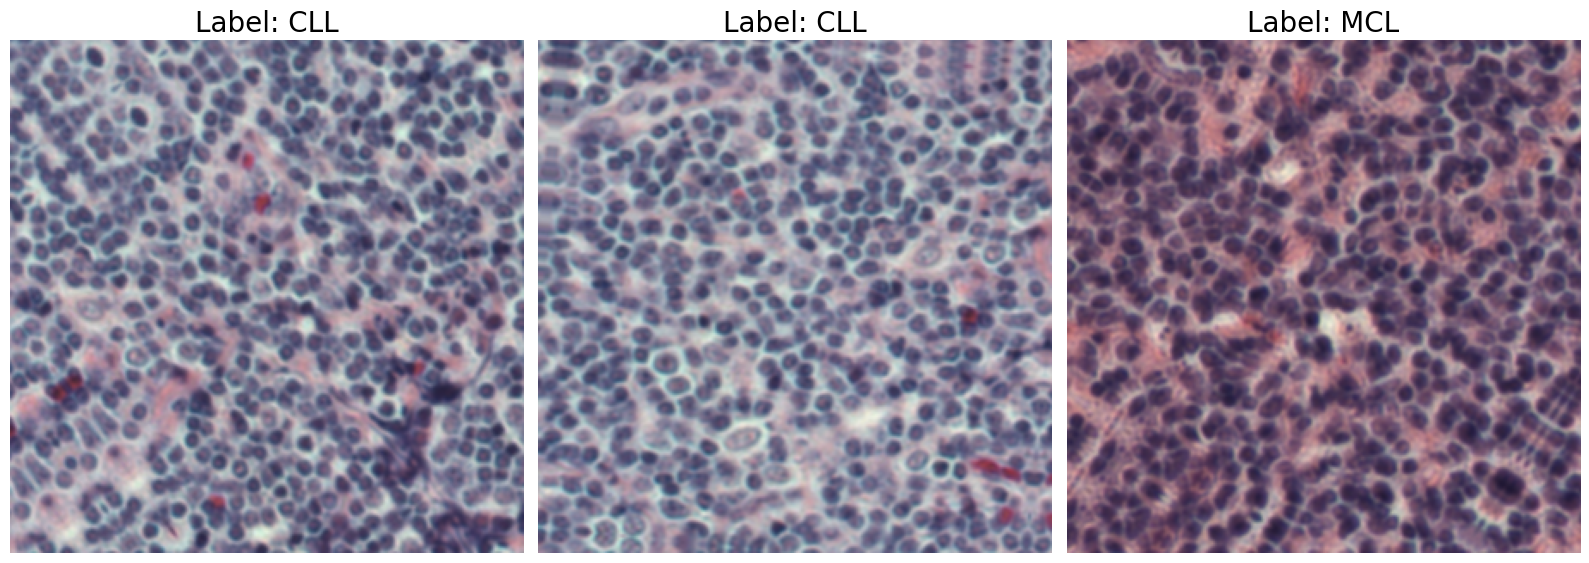

(32, 299, 299, 3) (32,)


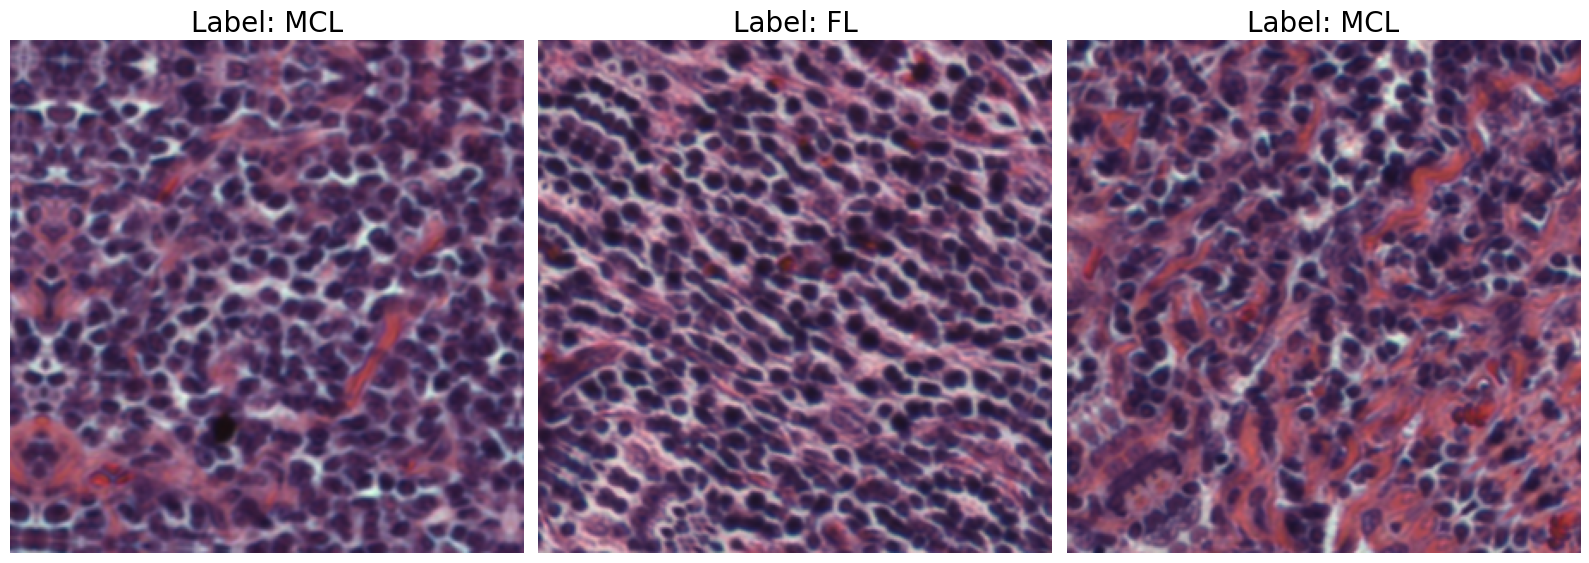

(32, 299, 299, 3) (32,)


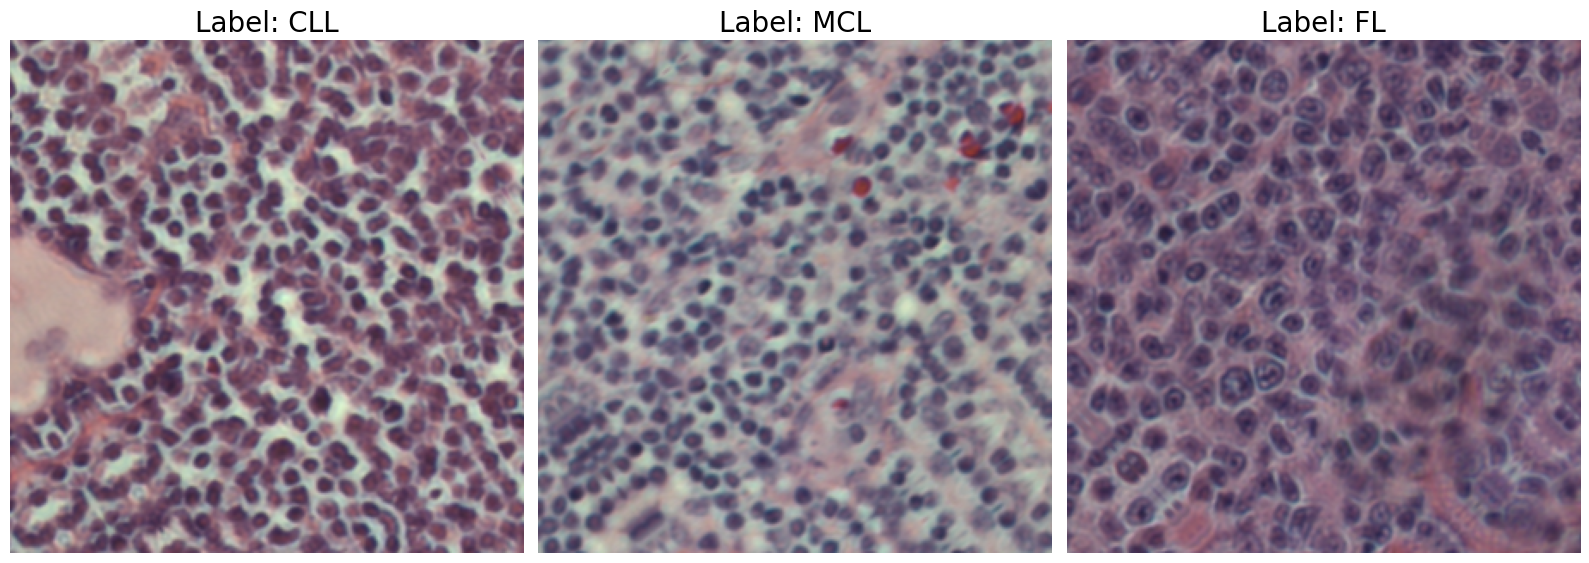

In [21]:
# plot some images
import matplotlib.pyplot as plt

cmap = 'gray' if COLOR_SPACE == 'gray' else None

for patches, labels in train_dataset.take(3):
    fig, axes = plt.subplots(1, 3, figsize=(16,16))
    print(patches.shape, labels.shape)
    for i in range(1):
        for j in range(3):
            axes[j].imshow(patches[i*8+j, :, :, :], cmap=cmap)
            label = labels[i*8+j]
            if label == 0:
                label = 'CLL'
            elif label == 1:
                label = 'FL'
            else:
                label = 'MCL'
            axes[j].title.set_text(f'Label: {label}')
            # increses the size of the title
            axes[j].title.set_fontsize(20)

    # hide the axis
    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Model

In [ ]:
# model = CNN(input_shape=(PATCH_SIZE, PATCH_SIZE, INPUT_CHANNELS), filters=(64,128,256,512), compression_depth=4)
model = Inception_v4(input_shape=(PATCH_SIZE, PATCH_SIZE, INPUT_CHANNELS))


In [ ]:
model.summary()

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
metrics = ['accuracy']

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, verbose=1, min_lr=1e-5)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [ ]:
checkpoint_path = './inception/inception'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_best_only=True,
                                                verbose=1)

backup_path = './inception_backup'
backup = tf.keras.callbacks.BackupAndRestore(backup_dir=backup_path,
                                             save_freq='epoch',
                                             delete_checkpoint=True)

logger = tf.keras.callbacks.CSVLogger('inception.csv', separator=',', append=True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = model.fit(train_dataset, epochs=100, steps_per_epoch=train_steps,
                    validation_data=val_dataset, validation_steps=val_steps,
                    callbacks=[lr_scheduler, early_stopping, checkpoint, backup, logger])

In [ ]:
# plot training and validation loss side by side with accuracies
hist = history.history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(hist['loss'], label='train')
axes[0].plot(hist['val_loss'], label='val')
axes[0].set_title('Loss')
# set y-axis to log scale
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot(hist['accuracy'], label='train')
axes[1].plot(hist['val_accuracy'], label='val')
axes[1].set_title('Accuracy')
axes[1].legend()